In [1]:
import os
os.chdir("../scripts/diffuser_icons")

In [2]:
from PIL import Image, ImageDraw, ImageFont
import json, random
import numpy as np
from dataset import draw_icon
import torch
from torch.nn import Conv2d

### Draw Icons

In [3]:
with open("../../data/matplotlib/unicode.jsonl", "r", encoding="unicode-escape") as f: lines = f.readlines()

icon: ♉ (taurus)


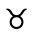

In [6]:
# draw a single icon
tmp = random.choice(lines)
tmp = json.loads(tmp)
unicode = (tmp[0], tmp[2])
print(f"icon: {tmp[0]} ({tmp[1]})")
im = draw_icon(unicode, unicode2=None, canvas_size=32, icon_size=32, fontsize=28)
im

icon1: ♯ (sharp_music)
icon2: ❝ (quotation_open)


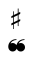

In [12]:
# draw a two icons 
tmp1, tmp2 = random.sample(lines, 2)
tmp1, tmp2 = json.loads(tmp1), json.loads(tmp2)
unicode1 = (tmp1[0], tmp1[2])
unicode2 = (tmp2[0], tmp2[2])
print(f"icon1: {tmp1[0]} ({tmp1[1]})\nicon2: {tmp2[0]} ({tmp2[1]})")
im = draw_icon(unicode1, unicode2, canvas_size=(64, 32), icon_size=32, fontsize=28)
im

### Evaluate Generated Icons

In [13]:
### Create all filters
icon_size, font_size = 32, 28
#icon_size, font_size = 128, 128, 120
GTHS = []
with open("../../data/nouns/all_nouns.txt", "r") as f: nouns = [x.strip() for x in f.readlines()]
with open("../../data/matplotlib/unicode.jsonl", "r", encoding="unicode-escape") as f: lines = f.readlines()
icons_names = [json.loads(x)[1] for x in lines]
nouns_to_names = {n:m for n, m in zip(nouns, icons_names)}
for l in lines:
    im = Image.new("RGB", (icon_size, icon_size), (255,255,255))
    draw = ImageDraw.Draw(im)
    unicode_text, _, font = json.loads(l)
    unicode_font = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    _, _, w, h = draw.textbbox((0, 0), unicode_text, font=unicode_font)
    draw.text(((icon_size-w)/2,(icon_size-h)/2), unicode_text, font=unicode_font, fill="black")
    y = torch.Tensor(np.asarray(im)/255 - 0.5).permute(2, 0, 1)
    GTHS.append(y)
GTHS = torch.stack(GTHS)
print(f"{len(lines)} icons in total, filter shape = {GTHS.shape}")

filter = Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=(icon_size, icon_size),
    bias=False
)


200 icons in total, filter shape = torch.Size([200, 3, 32, 32])


In [15]:
### Eval single object

img_path = "output/1213_154255/samples/4999_30000.png" # a batch of generated images is saved to the same file

im = Image.open(img_path).convert("RGB")
im_array = np.array(im, dtype=np.float64)
h, w, d = tuple(im_array.shape)

# Process the image collage and recover the batch_size dimension
num_rows, num_cols = int(h // icon_size), int(w // icon_size)
bs = num_rows * num_cols
pixels = np.reshape(im_array, (num_rows, icon_size, w, d))
pixels = np.reshape(pixels, (num_rows, icon_size, num_cols, icon_size, d))
pixels = np.transpose(pixels, (0, 2, 1, 3, 4))
pixels = np.reshape(pixels, (bs, icon_size, icon_size, d))

# Read the text prompts
with open(img_path.replace(".png", ".txt"), "r") as txt:
    input_texts = []
    for l in txt.readlines():
        if "=========" in l: break
        input_texts.append(l.strip())   

em, count = 0, 0           
for m, sentence in zip(pixels, input_texts):
    x = torch.Tensor(np.asarray(m)/255 - 0.5).permute(2, 0, 1)
    filter.weight.data = x.unsqueeze(0)
    output = filter(GTHS).squeeze()
    em += int(nouns[output.argmax().item()] == sentence.replace(".", "").split()[-1])
    count += 1


print(f"Evaluated {count} samples")
print(f"Acc = {em/count} ({em}/{count})")

Evaluated 20 samples
Acc = 1.0 (20/20)


In [16]:
## Eval two objects

img_path = "output/0213_235617/samples/599_58802.png" # a batch of generated images is saved to the same file

im = Image.open(img_path).convert("RGB")
im_array = np.array(im, dtype=np.float64)
h, w, d = tuple(im_array.shape)

# Process the image collage and recover the batch_size dimension
image_height, image_width, icon_size = 64, 32, 32
num_rows, num_cols = int(h // image_height), int(w // image_width)
bs = num_rows * num_cols
pixels = np.reshape(im_array, (num_rows, image_height, w, d))
pixels = np.reshape(pixels, (num_rows, image_height, num_cols, image_width, d))
pixels = np.transpose(pixels, (0, 2, 1, 3, 4))
pixels = np.reshape(pixels, (bs, image_height, image_width, d))

# Read the text prompts
with open(img_path.replace(".png", ".txt"), "r") as txt:
    l = "".join(txt.readlines()).split("============")[0].strip().split("\n")
    input_texts = [x.strip() for x in l]

em, count = 0, 0
for m, sentence in zip(pixels, input_texts):
    upper_m, lower_m = m[:icon_size,:], m[icon_size:,:] 
    objects = [w for w in sentence.replace(".", "").split() if w in nouns]
    if "bottom" in sentence: objects = objects[::-1]
    upper_o, lower_o = objects # gth objects

    x = torch.Tensor(np.asarray(upper_m)/255 - 0.5).permute(2, 0, 1)
    filter.weight.data = x.unsqueeze(0)
    output = filter(GTHS).squeeze()
    upper_gen = nouns[output.argmax().item()]
    upper_em = int(upper_gen == upper_o)

    x = torch.Tensor(np.asarray(lower_m)/255 - 0.5).permute(2, 0, 1)
    filter.weight.data = x.unsqueeze(0)
    output = filter(GTHS).squeeze()
    lower_gen = nouns[output.argmax().item()]
    lower_em = int(lower_gen == lower_o)
    
    em += upper_em * lower_em # em = 1 if both objects are correct
    count += 1

print(f"Evaluated {count} samples")
print(f"Acc = {em/count} ({em}/{count})")


Evaluated 20 samples
Acc = 0.65 (13/20)
